In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [2]:
# Specify data paths
dataset = './model/Hand_Point/HandPoint.csv'
model_save_path = './model/Hand_Point/HandPoint.hdf5'
tflite_save_path = './model/Hand_Point/HandPoint.tflite'

# Set number of classes

In [3]:
# Change training classes if necessary
NUM_CLASSES = 26

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

<AxesSubplot:>

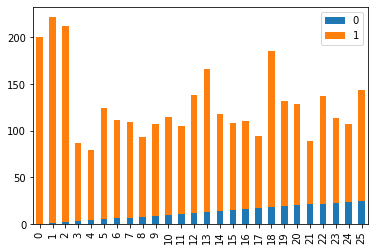

In [7]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
# print(counts)

# Model building

In [8]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(21 * 2, )),
        tf.keras.layers.Reshape((1, 21 * 2), input_shape=(21 * 2, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(44, input_shape=[1, 21 * 2]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((21 * 2, )),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(52, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(52, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(21, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [9]:
#tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 52)                2236      
                                                                 
 dropout_1 (Dropout)         (None, 52)                0         
                                                                 
 dense_1 (Dense)             (None, 52)                2756      
                                                                 
 dropout_2 (Dropout)         (None, 52)                0         
                                                                 
 dense_2 (Dense)             (None, 21)                1113      
                                                                 
 dense_3 (Dense)             (None, 26)                5

In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
36/38 [===========================>..] - ETA: 0s - loss: 3.2165 - accuracy: 0.0573
Epoch 1: val_loss improved from inf to 3.10591, saving model to ./model/Hand_Point\HandPoint.hdf5
38/38 [==============================] - 1s 14ms/step - loss: 3.2118 - accuracy: 0.0593 - val_loss: 3.1059 - val_accuracy: 0.0995
Epoch 2/1000
28/38 [=====================>........] - ETA: 0s - loss: 3.0723 - accuracy: 0.0971
Epoch 2: val_loss improved from 3.10591 to 2.86325, saving model to ./model/Hand_Point\HandPoint.hdf5
38/38 [==============================] - 0s 11ms/step - loss: 3.0386 - accuracy: 0.1099 - val_loss: 2.8633 - val_accuracy: 0.1857
Epoch 3/1000
19/38 [==============>...............] - ETA: 0s - loss: 2.8896 - accuracy: 0.1480
Epoch 3: val_loss improved from 2.86325 to 2.56526, saving model to ./model/Hand_Point\HandPoint.hdf5
38/38 [==============================] - 0s 7ms/step - loss: 2.8123 - accuracy: 0.1701 - val_loss: 2.5653 - val_accuracy: 0.2272
Epoch 4/1000
22/38 [=

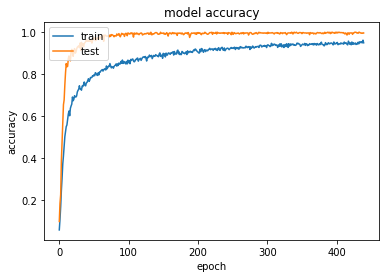

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

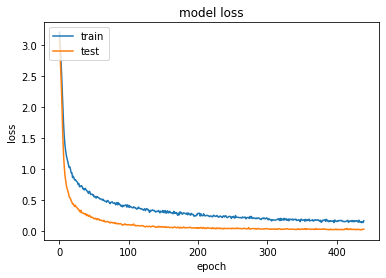

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [17]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

10/10 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 1.0000


In [18]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 133ms/step
[2.76006440e-09 9.93047059e-01 2.48687429e-04 3.26117970e-07
 4.84285265e-04 6.18812488e-03 1.08997555e-14 1.76566406e-08
 8.12905569e-07 6.10974303e-06 4.35375034e-17 6.77406604e-14
 1.19578814e-09 6.44611991e-17 9.36594552e-06 9.86357263e-12
 1.24409198e-05 9.20272498e-07 9.98823566e-07 8.51285152e-18
 1.27166640e-14 1.18175894e-14 7.53322638e-07 8.33084093e-15
 1.74167226e-11 7.36794862e-14]
1


# Confusion matrix

19/19 [==============================] - 0s 2ms/step


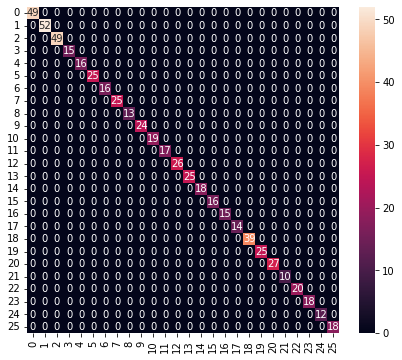

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        52
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        24
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00        26
          13       1.00      1.00      1.00        25
          14       1.00      1.00      1.00        18
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00        15
     

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [20]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [21]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\LETUAN~1\AppData\Local\Temp\tmpycr419q_\assets


11336

## Inference test

In [22]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [23]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [24]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [25]:
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [26]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.8617657e-09 9.9234504e-01 2.5088721e-04 3.0812853e-07 5.2478071e-04
 6.8482473e-03 8.8365476e-15 1.4936036e-08 8.4096172e-07 5.7572329e-06
 3.3410612e-17 6.1055205e-14 9.9678321e-10 4.9176175e-17 9.3642166e-06
 9.0988753e-12 1.2377941e-05 7.8187054e-07 9.4735185e-07 7.5567300e-18
 9.6322427e-15 9.2191718e-15 6.2984412e-07 6.8019672e-15 1.8738426e-11
 5.8576848e-14]
1
